# Sentiment Analysis 

Text classification and sentiment analysis using BERT and pytorch

BERT in comparison to ELMO uses transformer architechture, and doesn't use LSTMs. BERT uses contextual word embeddings which means that a single word could have multiple meanings, and BERT does account for that in the word embeddings based on the context of the sentence in which it occurs. 

Transformers feeds the input at once when compared to sequential model of LSTMs. They prove to perform better on tasks like Q/A systems, comprehension of text etc. 

## BERT :

GPT model does L-R understanding of the text. Sometimes Q/A systems have answers after the current text read. BERT is **bidirectional** which means that it reads from both ends and captures the details in its entirity.

It can be easily fine-tuned for the task that is required. BERT model was trained (pre-trained) using MLM (masked language modelling) and NSP (next sentence prediction).

15% of the words were masked and the model was to predict the masked words. NSP was given 2 sentences and it had to predict whether or not the second sentence follows the first (in a sensible manner)

## NOTATIONS 

[CLS] \<sentence\> [SEP]

[CLS] token signifies the classification token. and [SEP] signifies a separater token.

## BERT and Huggingface

The two kinds of models : 
* Bert Base - 12 encoders stacked
* Bert large - 24 encoders stacked

In [1]:
from google.colab import drive
drive.mount('/content/gdrive')

Drive already mounted at /content/gdrive; to attempt to forcibly remount, call drive.mount("/content/gdrive", force_remount=True).


In [2]:
import warnings
warnings.filterwarnings('ignore')

In [3]:
root_path = "/content/gdrive/MyDrive/Collab-Notebooks/Sentiment-Analysis/"

In [4]:
!pip install transformers

In [5]:
import transformers
from transformers import BertModel, BertTokenizer, AdamW, get_linear_schedule_with_warmup
import torch

import numpy as np
import pandas as pd
import seaborn as sns

from pylab import rcParams

import matplotlib.pyplot as plt
from matplotlib import rc

from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix, classification_report

from collections import defaultdict
from textwrap import wrap
from torch import nn, optim
from torch.utils.data import Dataset, DataLoader

%matplotlib inline
%config InlineBackend.figure_format='retina'

sns.set(style='whitegrid', palette='muted', font_scale=1.2)
HAPPY_COLORS_PALETTE = ["#01BEFE", "#FFDD00", "#FF7D00", "#FF006D", "#ADFF02", "#8F00FF"]
sns.set_palette(sns.color_palette(HAPPY_COLORS_PALETTE))
rcParams['figure.figsize'] = 12,8

RANDOM_SEED = 42
np.random.seed(RANDOM_SEED)
torch.manual_seed(RANDOM_SEED)

device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

In [6]:
df = pd.read_csv(root_path+"reviews.csv")
df.head()

,reviewId,userName,userImage,content,score,thumbsUpCount,reviewCreatedVersion,at,replyContent,repliedAt,sortOrder,appId
0,gp:AOqpTOGOU1svA5gsifHKHFSziUGg7FDs9zR0HbVyXya...,trina croll,https://play-lh.googleusercontent.com/a-/AOh14...,Can't get into my account and it's been days g...,1,8,5.7.0.20,2020-12-21 01:58:55,NaN,NaN,most_relevant,com.anydo
1,gp:AOqpTOEJfVU5Os7_8CNOu_mpy2AlDz8kFxEFMeBMnxC...,Yiğitcan Sümbelli,https://play-lh.googleusercontent.com/a-/AOh14...,I am starting to hate this app! Every time the...,1,63,5.7.0.10,2020-12-02 15:52:24,"Hi, please note that these issues usually are ...",2020-12-03 20:47:02,most_relevant,com.anydo
2,gp:AOqpTOHhd6uZpuhbBDDxEB1SwF8zXXUh8sg6AMGlkBx...,Chris Keyes,https://play-lh.googleusercontent.com/a-/AOh14...,I paid premium for years. No more! This app ha...,1,24,5.7.0.10,2020-12-15 00:58:57,Sorry you feel this way. Any.do does not chang...,2020-12-17 09:28:09,most_relevant,com.anydo
3,gp:AOqpTOFSPaoOVarqwKF86e7-TPUyV6BanSXKRNFGb6G...,Jon Pember,https://play-lh.googleusercontent.com/-97UNn5D...,"Liked Any.do at first, enough that I even sign...",1,102,5.7.0.10,2020-11-22 23:42:56,Please note that Any.do integrates directly wi...,2020-11-25 13:30:01,most_relevant,com.anydo
4,gp:AOqpTOEA0ubPA5n0s_6lg0BHqfQqj0gi-KIdZF_I1yZ...,Lisa Pappas,https://play-lh.googleusercontent.com/a-/AOh14...,Constant crashing. After reading all the negat...,1,25,5.6.0.6,2020-10-21 17:45:24,NaN,NaN,most_relevant,com.anydo


In [7]:
df.shape

(16354, 12)

In [8]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 16354 entries, 0 to 16353
Data columns (total 12 columns):
 #   Column                Non-Null Count  Dtype 
---  ------                --------------  ----- 
 0   reviewId              16354 non-null  object
 1   userName              16354 non-null  object
 2   userImage             16354 non-null  object
 3   content               16354 non-null  object
 4   score                 16354 non-null  int64 
 5   thumbsUpCount         16354 non-null  int64 
 6   reviewCreatedVersion  13988 non-null  object
 7   at                    16354 non-null  object
 8   replyContent          8740 non-null   object
 9   repliedAt             8740 non-null   object
 10  sortOrder             16354 non-null  object
 11  appId                 16354 non-null  object
dtypes: int64(2), object(10)
memory usage: 1.5+ MB


To check whether or not our dataset is balanced in terms of the dataset distribution that we have. We can check this with respect to the count of the different scores.

The distribution seems reasonable since (1,2) will be grouped and (4,5) will be grouped and 3 is double of that

Text(0.5, 0, 'review score')

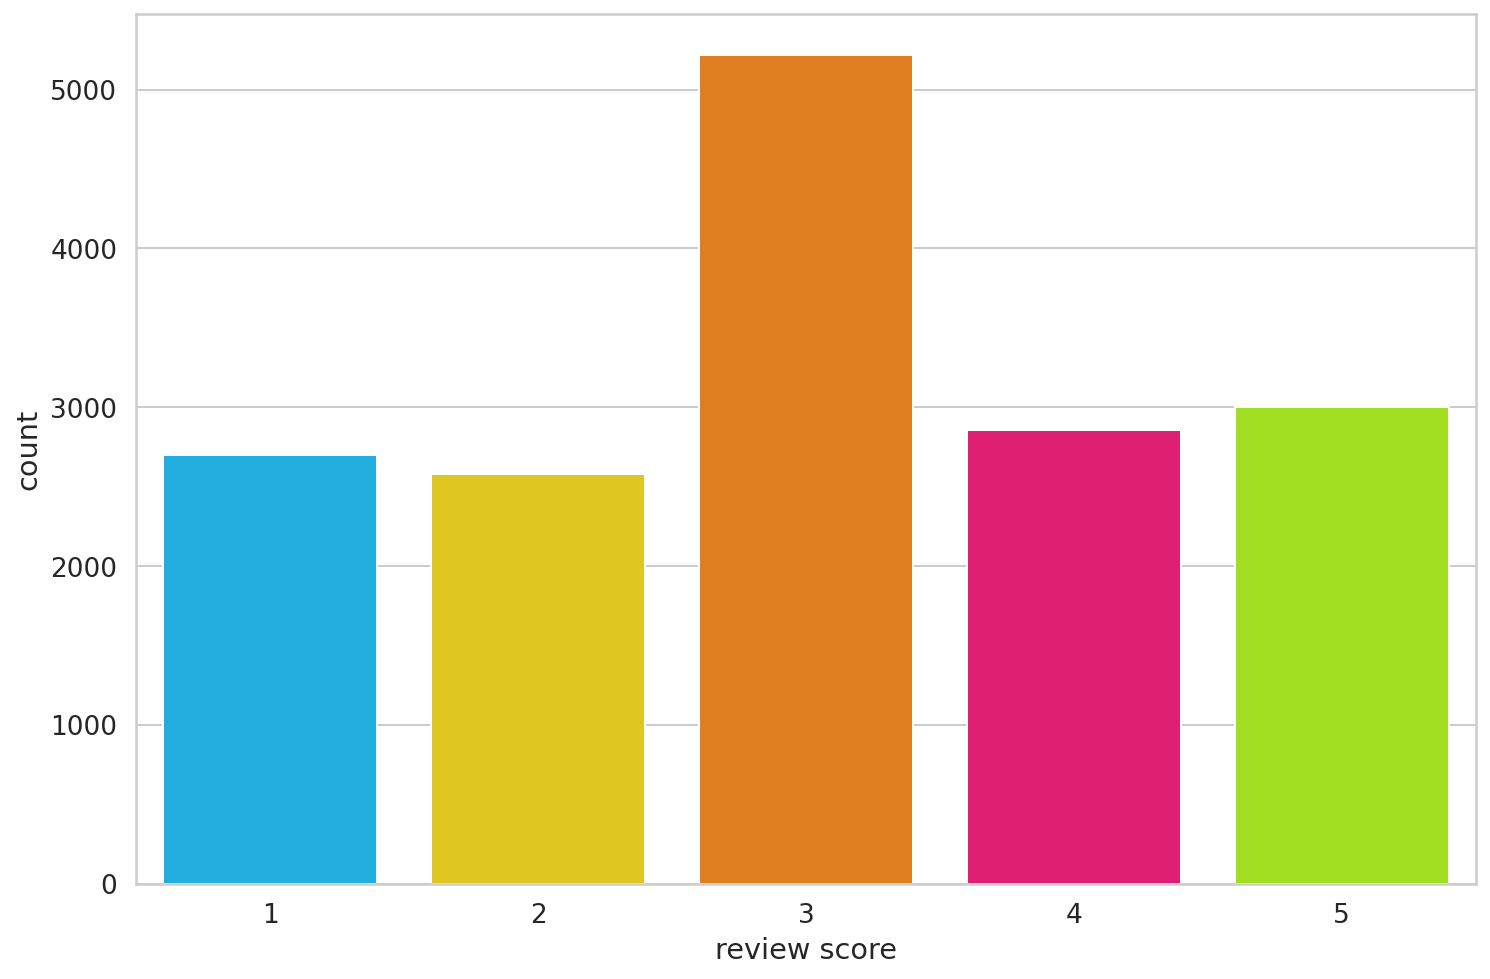

In [9]:
sns.countplot(df.score)
plt.xlabel('review score')

In [10]:
def to_sentiment(rating):
  rating = int(rating)
  if rating <=2:
    return 0
  elif rating == 3:
    return 1
  else:
    return 2

In [11]:
df['sentiment'] = df.score.apply(to_sentiment)

In [12]:
class_names = ['negative','neutral','positive']

[Text(0, 0, 'negative'), Text(0, 0, 'neutral'), Text(0, 0, 'positive')]

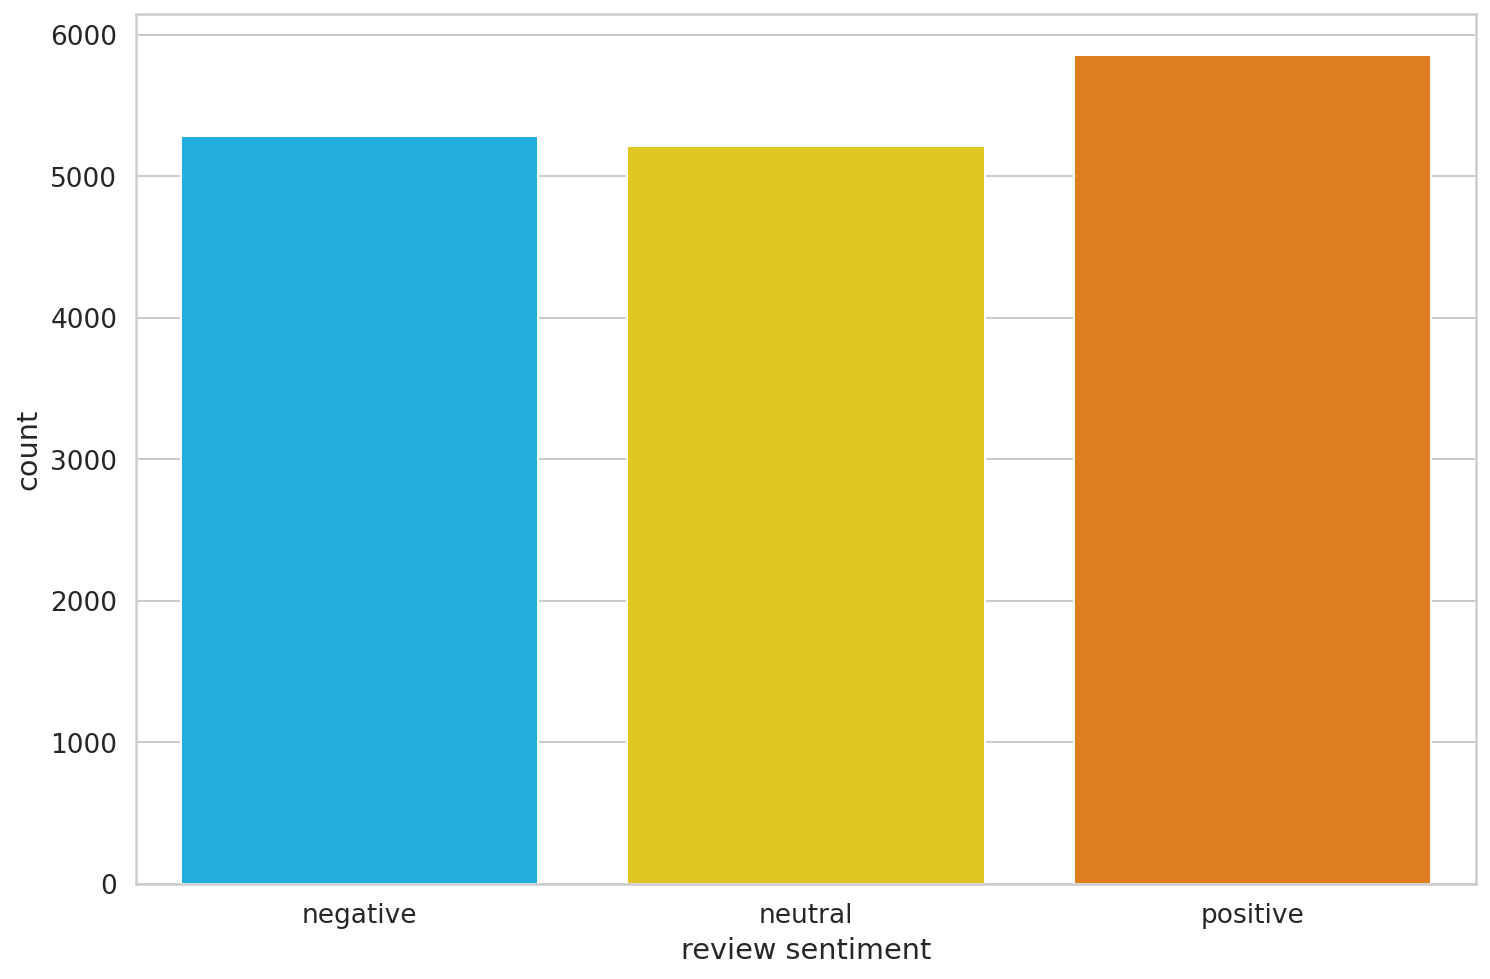

In [13]:
ax =sns.countplot(df.sentiment)
plt.xlabel('review sentiment')
ax.set_xticklabels(class_names)

# Data Preprocessing

BERT transformer requires some special work on the text as preprocessing. Pretrained on v large dataset; and we are using it for sequence classification

In [14]:
#starting with the tokenizer
PRE_TRAINED_MODEL_NAME = 'bert-base-cased'
tokenizer = BertTokenizer.from_pretrained(PRE_TRAINED_MODEL_NAME)


BERT requires special tokens which indicate separation between sentences.
This comes from the fact that BERT was initially built for Q/A systems and while
doing classification of sequences BERT requires a tokens

Seuqences must be of equal length, which means we'll have to do padding which will
append tokens of 0 meaning to the end of our sentences that we pass into the model

We also require an attention mask - each token that has a meaning should have a value
of 1 in the attention mask, else if it is a padding token attention mask should be 0

* Use a small piece of text to show how the tokenizer splits and works with the text

* Building a dataset, that will take the reviews, use the tokenizer internally, and build a dataset that is compatible with pytorch

In [15]:
sample_txt = "When was I last outside? I am stuck at home for 2 weeks."

In [16]:
tokens = tokenizer.tokenize(sample_txt)

In [17]:
print(tokens)
#keeps all the punctuation here

['When', 'was', 'I', 'last', 'outside', '?', 'I', 'am', 'stuck', 'at', 'home', 'for', '2', 'weeks', '.']


In [18]:
#converting tokens to ids to pass to the bert model later

token_ids = tokenizer.convert_tokens_to_ids(tokens)
print(len(token_ids))
print(len(tokens))
print(token_ids)

15
15
[1332, 1108, 146, 1314, 1796, 136, 146, 1821, 5342, 1120, 1313, 1111, 123, 2277, 119]


## Special Tokens

* SEP tokens
* Classification token
* Padding token
* Unknown token for something that is unrecognized

We use the ecode plus method to create all the steps for tokenization and data pre processing

In [19]:
tokenizer.sep_token, tokenizer.sep_token_id

('[SEP]', 102)

In [20]:
tokenizer.cls_token, tokenizer.cls_token_id

('[CLS]', 101)

In [21]:
tokenizer.pad_token, tokenizer.pad_token_id

('[PAD]', 0)

In [22]:
tokenizer.unk_token, tokenizer.unk_token_id

('[UNK]', 100)

In [23]:
encoding = tokenizer.encode_plus(
    sample_txt,
    max_length = 32,
    add_special_tokens=True,
    pad_to_max_length = True,
    return_attention_mask = True,
    return_token_type_ids = False,
    return_tensors = 'pt'
)

encoding.keys()

dict_keys(['input_ids', 'attention_mask'])

In [24]:
encoding['input_ids']

tensor([[ 101, 1332, 1108,  146, 1314, 1796,  136,  146, 1821, 5342, 1120, 1313,
         1111,  123, 2277,  119,  102,    0,    0,    0,    0,    0,    0,    0,
            0,    0,    0,    0,    0,    0,    0,    0]])

In [25]:
len(encoding['input_ids'][0])

32

In [26]:
encoding['attention_mask']

tensor([[1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 0, 0, 0, 0, 0, 0,
         0, 0, 0, 0, 0, 0, 0, 0]])

### Choosing Sequence Length
We can look at the distribution of the sentences in our token lengths and the choose one ideal one

We will just use the encode method of the tokenizer here

In [27]:
token_lens = []

for txt in df.content:
  tokens = tokenizer.encode(txt, max_length=512, truncation=True)
  token_lens.append(len(tokens))

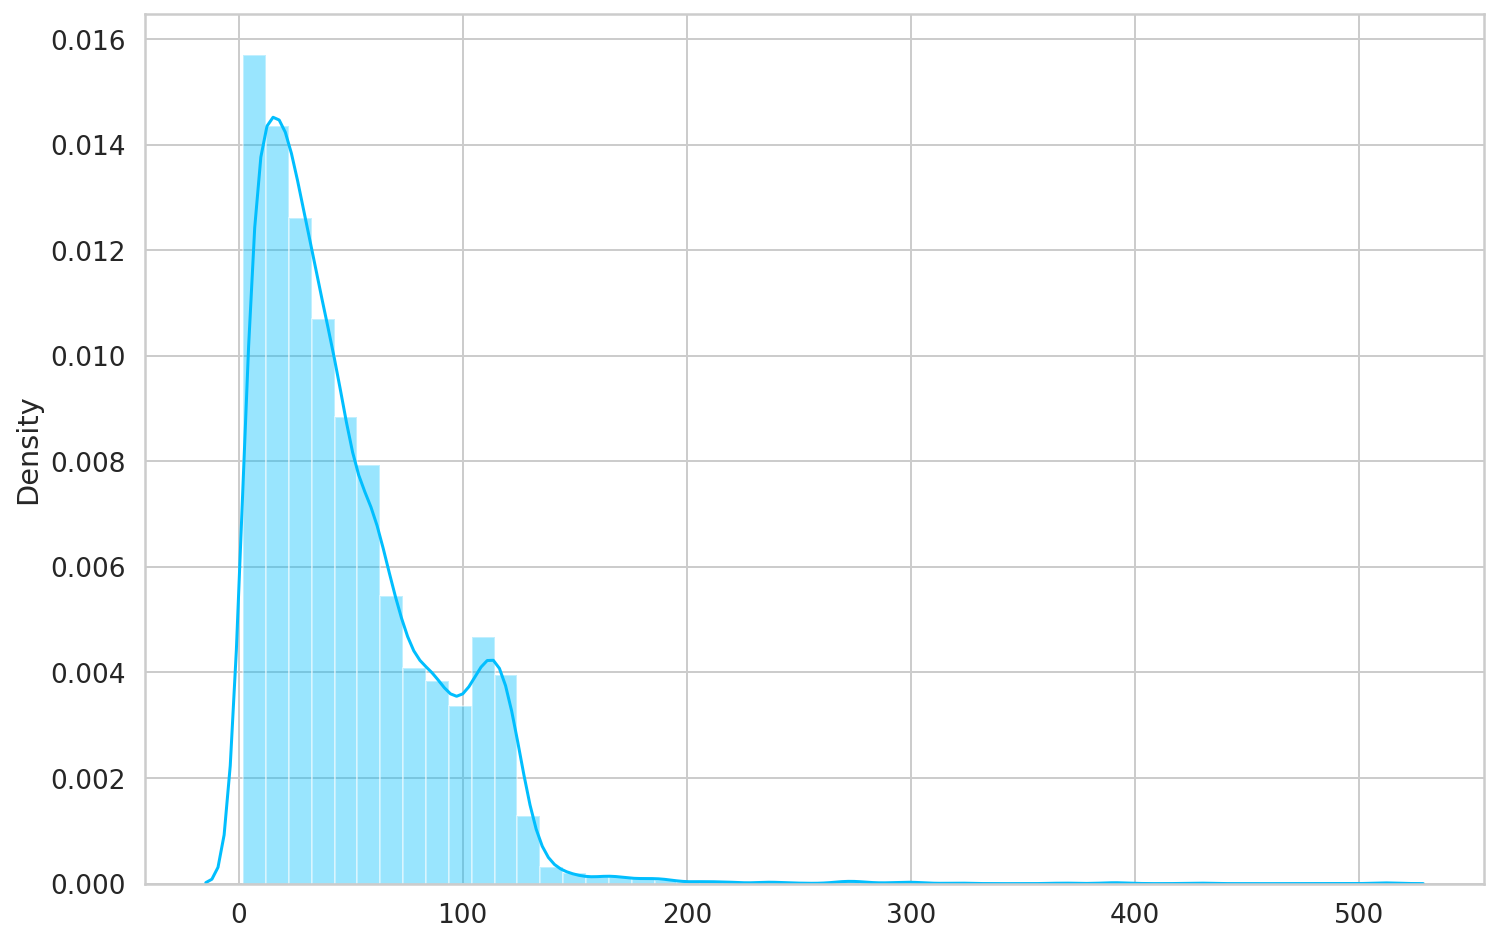

In [28]:
sns.distplot(token_lens)

Here the max length of 128 seems suitable enough for our distribution of tokens and initially, we can choose a len that may clip some tokens but allows the model to train relatively faster and also helps build a faster prototype for testing

## Creating a DATSET

In [29]:
class GPReviewDataset(Dataset):


  def __init__(self, review, targets, tokenizer, max_len):
    self.review = review
    self.targets = targets
    self.tokenizer = tokenizer
    self.max_len = max_len

  def __len__(self):
    return len(self.review)

  #takes the index of the element from the dataset
  def __getitem__(self, item):
    review = str(self.review[item])
    target = self.targets[item]

    encoding = tokenizer.encode_plus(
      review,
      max_length = self.max_len,
      add_special_tokens=True,
      pad_to_max_length = True,
      return_attention_mask = True,
      return_token_type_ids = False,
      return_tensors = 'pt'
    )
    return {
        'review_text' : review,
        'input_ids' : encoding['input_ids'].flatten(),
        'attention_mask' : encoding['attention_mask'].flatten(),
        'targets' : torch.tensor(target, dtype=torch.long)
    }
  

In [30]:
MAX_LEN = 160
BATCH_SIZE = 16
EPOCHS = 50

In [31]:
#splitting into train, test, val

df_train, df_test = train_test_split(df, test_size=0.1, random_state=RANDOM_SEED)
df_val, df_test = train_test_split(df_test, test_size = 0.5, random_state=RANDOM_SEED)

In [32]:
df_train.shape, df_val.shape, df_test.shape

((14718, 13), (818, 13), (818, 13))

In [33]:
'''
wrapping all the dataframes into the pytorch dataloaders 
to be able to load and use in the bert pretrained model
'''

def create_data_loader(df, tokenizer, max_len, batch_size):
  ds = GPReviewDataset(
      review = df.content.to_numpy(),
      targets = df.sentiment.to_numpy(),
      tokenizer = tokenizer,
      max_len = max_len
  )

  return DataLoader(
      ds,
      batch_size = batch_size,
      num_workers = 4
  )

In [34]:
train_data_loader = create_data_loader(df_train, tokenizer, MAX_LEN, BATCH_SIZE)
val_data_loader = create_data_loader(df_val, tokenizer, MAX_LEN, BATCH_SIZE)
test_data_loader = create_data_loader(df_test, tokenizer, MAX_LEN, BATCH_SIZE)

In [35]:
data = next(iter(train_data_loader))
data = next(iter(train_data_loader))
data = next(iter(train_data_loader))
data = next(iter(train_data_loader))
data = next(iter(train_data_loader))
data = next(iter(train_data_loader))
data = next(iter(train_data_loader))
data = next(iter(train_data_loader))
data = next(iter(train_data_loader))
data = next(iter(train_data_loader))
data.keys()

dict_keys(['review_text', 'input_ids', 'attention_mask', 'targets'])

In [36]:
print(data['input_ids'].shape)

torch.Size([16, 160])


In [37]:
#initializing a BERT model

bert_model = BertModel.from_pretrained(PRE_TRAINED_MODEL_NAME)

In [38]:
#returns the last hidden state from the last encoder in the transformer
# also returns the pooled output

outputs = bert_model(
  input_ids=encoding['input_ids'],
  attention_mask=encoding['attention_mask']
)

In [39]:
last_hidden_state = outputs[0]
pooled_output = outputs[1]

In [40]:
last_hidden_state.shape

torch.Size([1, 32, 768])

768 hidden units in the last state of the topmost encoder

In [41]:
pooled_output.shape

torch.Size([1, 768])

Pooling procedure over the 32 elements into this dimension. It takes the hidden size of the 768 and applying tanh function over it : getting a summary of the hidden state

In [42]:
bert_model.config.hidden_size

768

## Building the Classifier

Creating a new class - extension of the torch nn module. 
* accepting number of classes that exist
* feed the data to BERT model
* apply drop out for regularization
* apply a softmax function for the final classification

In [43]:
class SentimentClassifier(nn.Module):

  def __init__(self, n_classes):
    super(SentimentClassifier,self).__init__()
    self.bert = BertModel.from_pretrained(PRE_TRAINED_MODEL_NAME)
    self.drop = nn.Dropout(p=0.3)
    self.out = nn.Linear(self.bert.config.hidden_size, n_classes)
    self.softmax = nn.Softmax(dim = 1)

  def forward(self, input_ids, attention_mask):
    outputs = self.bert(
        input_ids = input_ids,
        attention_mask = attention_mask
    )
    pooled_output = outputs[1]

    output = self.drop(pooled_output)
    output = self.out(output)
    return self.softmax(output)

In [44]:
model = SentimentClassifier(len(class_names))
model = model.to(device)

In [45]:
#checking the shapes on one batch, and to ensure a sanity check
# before we move further ahead

input_ids = data['input_ids'].to(device)
attention_mask = data['attention_mask'].to(device)

print(input_ids.shape)
print(attention_mask.shape)

torch.Size([16, 160])
torch.Size([16, 160])


In [46]:
model(input_ids, attention_mask)

tensor([[0.1602, 0.3840, 0.4558],
        [0.2467, 0.4210, 0.3323],
        [0.2323, 0.4162, 0.3515],
        [0.2433, 0.4224, 0.3344],
        [0.2179, 0.4080, 0.3741],
        [0.2323, 0.3397, 0.4280],
        [0.2145, 0.2355, 0.5499],
        [0.1596, 0.3974, 0.4431],
        [0.2659, 0.4495, 0.2845],
        [0.1907, 0.3905, 0.4189],
        [0.1964, 0.4000, 0.4036],
        [0.1375, 0.4762, 0.3863],
        [0.3216, 0.3366, 0.3418],
        [0.1708, 0.3874, 0.4418],
        [0.1513, 0.2914, 0.5573],
        [0.2821, 0.4829, 0.2350]], device='cuda:0', grad_fn=<SoftmaxBackward>)

## Model Training

* We use an AdamW optimizer (with weight decay fix)
* Linear scheduler to decay the learning rate
* Cross entropy loss since we're using it for classification

In [47]:
optimizer = AdamW(model.parameters(), lr=2e-5, correct_bias=False)

total_steps = len(train_data_loader)*EPOCHS #batches times epochs

scheduler = get_linear_schedule_with_warmup(
    optimizer,
    num_warmup_steps = 0,
    num_training_steps = total_steps
)

loss_fn = nn.CrossEntropyLoss().to(device)

In [48]:
#helper function for training

def train_epoch(
    model, 
    data_loader,
    loss_fn,
    optimizer,
    device,
    scheduler,
    n_examples
):
  model = model.train()
  losses = []
  correct_predictions = 0

  for d in data_loader :
    input_ids = d['input_ids'].to(device)
    attention_mask = d['attention_mask'].to(device)
    targets = d['targets'].to(device)

    outputs = model(
        input_ids = input_ids,
        attention_mask = attention_mask
    )

    _, pred = torch.max(outputs, dim=1)
    loss = loss_fn(outputs, targets)

    correct_predictions += torch.sum(pred == targets)
    losses.append(loss.item())

    #backpropagation steps
    loss.backward()

    #gradient clipping on our model : duplicating steps that BERT original describes
    #way to combat the exploding gradients and preventing the instability of the training/model
    nn.utils.clip_grad_norm_(model.parameters(), max_norm=1.0)

    #step of the optimizer
    optimizer.step()
    scheduler.step()
    optimizer.zero_grad()

  #retain the number of correct predictions and the mean loss
  return correct_predictions.double() / n_examples, np.mean(losses)

In [49]:
'''
helper function to evaluate the current model
batch normalization and drop out arent enabled in the eval mode
similar to validation evaluation
'''

def eval_model(model, data_loader, loss_fn, device, n_examples):
  model = model.eval()

  losses = []
  correct_predictions = 0  

  #disabling gradient functions so torch is faster

  with torch.no_grad():
    for d in data_loader:
      input_ids = d['input_ids'].to(device)
      attention_mask = d['attention_mask'].to(device)
      targets = d['targets'].to(device)

      outputs = model(
          input_ids = input_ids,
          attention_mask = attention_mask
      )

      _, pred = torch.max(outputs, dim=1)
      loss = loss_fn(outputs, targets)

      correct_predictions += torch.sum(pred == targets)
      losses.append(loss.item())

      #no training so nothing else here. 
  return correct_predictions.double() / n_examples, np.mean(losses)

In [50]:
#creating the training coup with the help of both of the above functions

history = defaultdict(list)
best_accuracy = 0

for epoch in range(EPOCHS):

  print(f'Epoch {epoch+1}/{EPOCHS}')
  print('-'*10)

  train_acc, train_loss = train_epoch(
      model,
      train_data_loader,
      loss_fn,
      optimizer,
      device, 
      scheduler,
      len(df_train)
  )

  print(f'Train Loss {train_loss} accuracy {train_acc}')

  val_acc, val_loss = eval_model(
      model,
      val_data_loader,
      loss_fn,
      device,
      len(df_val)
  )
  print(f'Val  Loss {val_loss} accuracy {val_acc}')
  print()

  history['train_acc'].append(train_acc)
  history['train_loss'].append(train_loss)

  history['val_acc'].append(val_acc)
  history['val_loss'].append(val_loss)

  if val_acc > best_accuracy:
    torch.save(model.state_dict(), root_path+'model.bin')
    best_accuracy = val_acc

Epoch 1/50
----------
Train Loss 0.9030266600458519 accuracy 0.6288897948090774
Val  Loss 0.8272772866946 accuracy 0.7127139364303179

Epoch 2/50
----------
Train Loss 0.8061144787332286 accuracy 0.739842369887213
Val  Loss 0.8141079694032669 accuracy 0.7249388753056235

Epoch 3/50
----------
Train Loss 0.7546095130236252 accuracy 0.7946731892920234
Val  Loss 0.8163407697127416 accuracy 0.726161369193154

Epoch 4/50
----------
Train Loss 0.7362146293339522 accuracy 0.8132898491642886
Val  Loss 0.791134407887092 accuracy 0.7506112469437652

Epoch 5/50
----------
Train Loss 0.7255059262980585 accuracy 0.8244326674819948
Val  Loss 0.7880381425985923 accuracy 0.7579462102689487

Epoch 6/50
----------
Train Loss 0.7102927478111308 accuracy 0.8399239027041717
Val  Loss 0.797409787774086 accuracy 0.7493887530562348

Epoch 7/50
----------
Train Loss 0.7058959507423899 accuracy 0.8440005435521131
Val  Loss 0.7707364650873038 accuracy 0.7750611246943765

Epoch 8/50
----------
Train Loss 0.695676

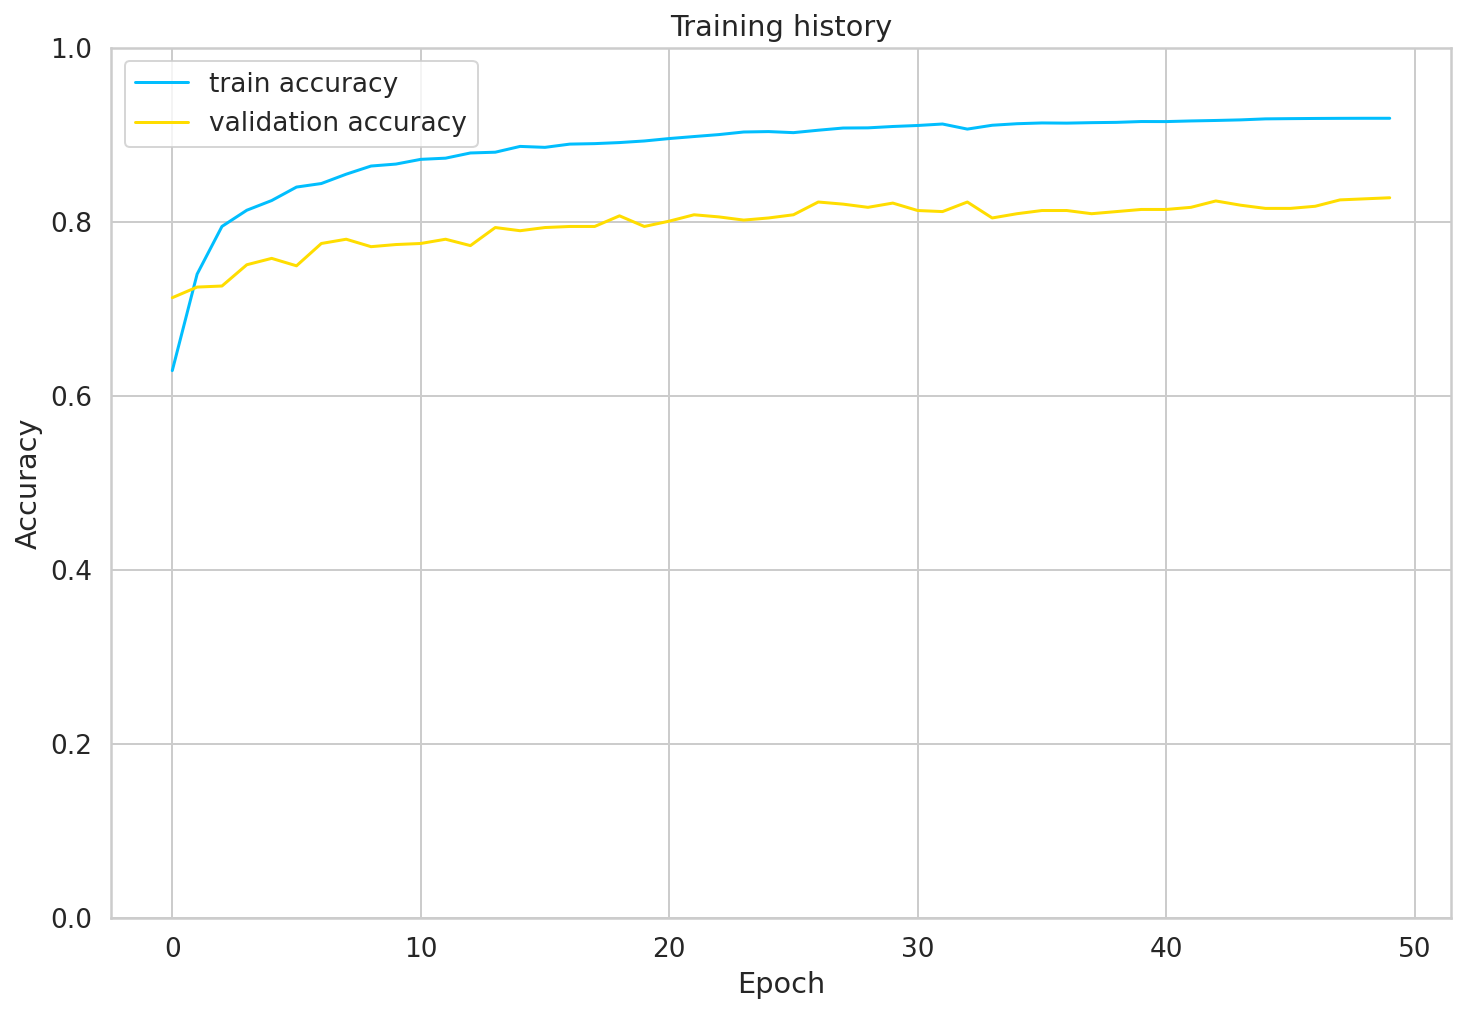

In [51]:
plt.plot(history['train_acc'], label='train accuracy')
plt.plot(history['val_acc'], label='validation accuracy')
plt.title('Training history')

plt.ylabel('Accuracy')
plt.xlabel('Epoch')

plt.legend()
plt.ylim([0, 1]);

In [52]:
MODEL_PATH = root_path+'model_base_cased_state_842.bin'
torch.save(model.state_dict(), MODEL_PATH)

In [53]:
#running the pretrained model

# !gdown --id 1V8itWtowCYnb2Bc9KlK9SxGff9WwmogA
# model = SentimentClassifier(len(class_names))
# model.load_state_dict(torch.load('best_model_state.bin'))
# model = model.to(device)

model = SentimentClassifier(len(class_names))
model.load_state_dict(torch.load(MODEL_PATH))
model = model.to(device)

# Evaluation of the Classifier

Function to return the text reviews, predictions of our models, prediction probabilities and the real sentiment values

In [54]:
def get_predictions(model, data_loader):
  model = model.eval() #eval mode

  review_texts = []
  predictions = []
  prediction_probs = []
  real_values = []

  with torch.no_grad():
    for d in data_loader:
      
      texts = d['review_text']
      input_ids = d['input_ids'].to(device)
      attention_mask = d['attention_mask'].to(device)
      targets = d['targets'].to(device)

      outputs = model(
        input_ids = input_ids,
        attention_mask = attention_mask
      )

      _, pred = torch.max(outputs, dim=1)

      review_texts.extend(texts)
      predictions.extend(pred)
      prediction_probs.extend(outputs)
      real_values.extend(targets)

    #converting list to tensors
    predictions = torch.stack(predictions).cpu() #converting list of tensors to single tensor
    prediction_probs = torch.stack(prediction_probs).cpu()
    real_values = torch.stack(real_values).cpu()

    return review_texts, predictions, prediction_probs, real_values


In [55]:
test_acc, test_loss = eval_model(model, test_data_loader, loss_fn, device, len(df_test))

In [56]:
test_acc

tensor(0.8142, device='cuda:0', dtype=torch.float64)

In [57]:
y_review_texts, y_pred, y_pred_probs, y_test = get_predictions(model, test_data_loader)

In [58]:
#evaluation using classification from scikit learn
print(classification_report(y_test, y_pred, target_names=class_names))

              precision    recall  f1-score   support

    negative       0.83      0.80      0.81       257
     neutral       0.75      0.75      0.75       253
    positive       0.85      0.88      0.86       308

    accuracy                           0.81       818
   macro avg       0.81      0.81      0.81       818
weighted avg       0.81      0.81      0.81       818



In [59]:
#getting confusion matrix for the corpus
def show_confusion_matrix(confusion_matrix):

  hmap = sns.heatmap(confusion_matrix, annot=True, fmt="d", cmap="Blues")
  hmap.yaxis.set_ticklabels(hmap.yaxis.get_ticklabels(), rotation=0, ha='right')
  hmap.xaxis.set_ticklabels(hmap.xaxis.get_ticklabels(), rotation=30, ha='right')
  plt.ylabel('True sentiment')
  plt.xlabel('Predicted sentiment');

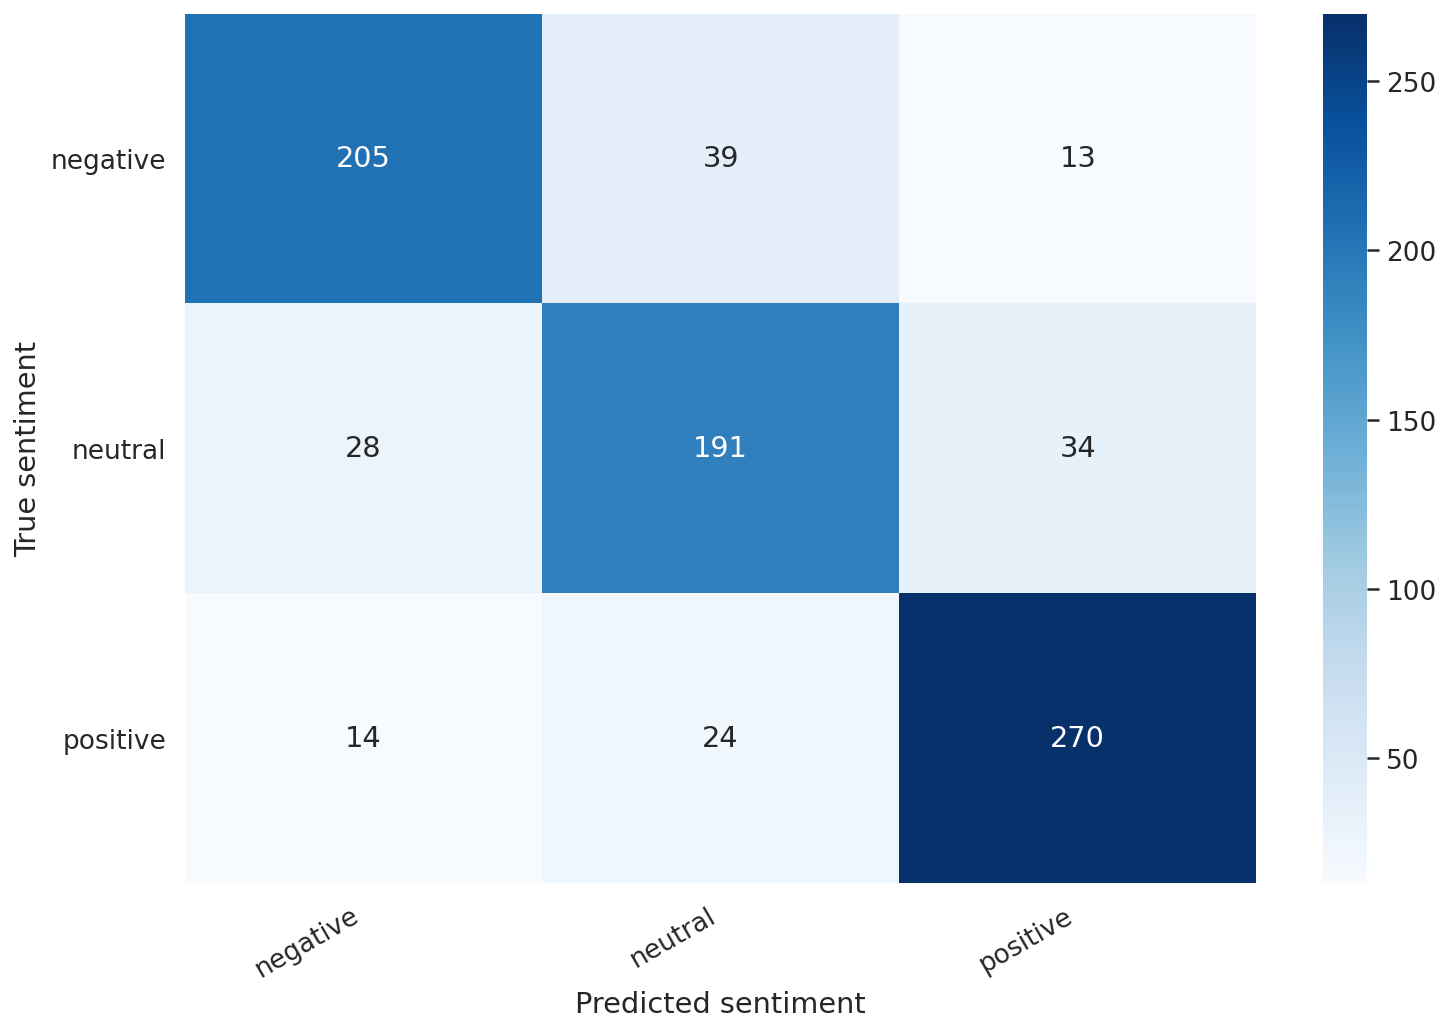

In [60]:
cm = confusion_matrix(y_test, y_pred)
df_cm = pd.DataFrame(cm, index=class_names, columns=class_names)
show_confusion_matrix(df_cm)

In [61]:
idx = 2
review_text = y_review_texts[idx]
true_sentiment = y_test[idx]

pred_df = pd.DataFrame({
    'class_names':class_names,
    'values' : y_pred_probs[idx]
})

In [62]:
print("\n".join(wrap(review_text)))
print()
print(f'True Sentiment : {class_names[true_sentiment]}')

It has helped me so much with school, and the google calender
integration makes it even better. Thank you!

True Sentiment : positive


(0.0, 1.0)

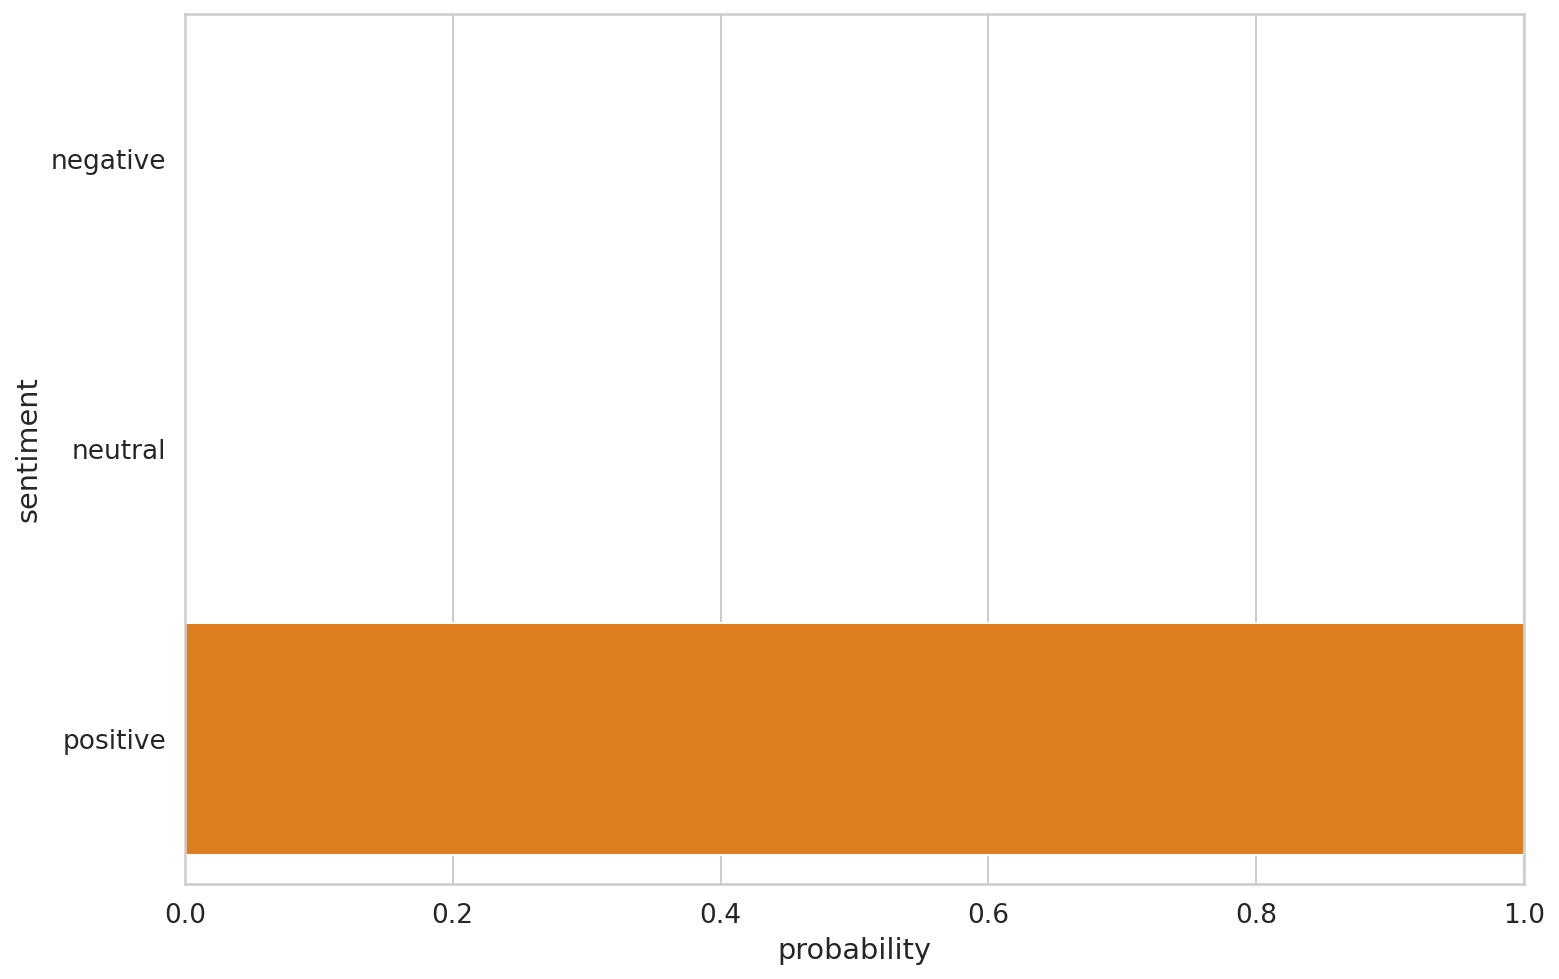

In [63]:
#checking with what the model thinks about the review

sns.barplot(x='values', y='class_names', data=pred_df, orient='h')
plt.ylabel('sentiment')
plt.xlabel('probability')
plt.xlim([0,1])

## Predictions on Raw Text

In [74]:
review_text = "I love completing my todos! Best app EVER!!!"

In [75]:
encoded_review = tokenizer.encode_plus(
    review_text,
    max_length=MAX_LEN,
    add_special_tokens = True,
    return_token_type_ids = False,
    pad_to_max_length = True,
    return_attention_mask = True,
    return_tensors = 'pt'
)

In [76]:
input_ids = encoded_review['input_ids'].to(device)
attention_mask = encoded_review['attention_mask'].to(device)

In [77]:
output = model(input_ids, attention_mask)
_,prediction = torch.max(output, dim=1)

In [78]:
print(f'Review Text:{review_text}')
print(f'Sentiment : {class_names[prediction]}')

Review Text:I love completing my todos! Best app EVER!!!
Sentiment : positive
